<h1><center>Programming Exercise 2:<br>Logistic Regression</center></h1>

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import minimize, fmin
import pandas as pd

mpl.rcParams['figure.figsize'] = (10,6)

# 1. Logistic Regression
- Assignment: As the administrator of a university department determine each applicant's chance of admission based on the results of two exams

## 1.1 Visualizing the Data

In [2]:
scores1,scores2,class_label = np.loadtxt('ex2data1.txt',delimiter=',',unpack=True)

# Let's build the design matrix
design = np.c_[np.ones_like(scores1),scores1,scores2]
# and theta initialized to zero's right away
theta = np.zeros(np.shape(design)[1])

admit_cut = (class_label==1) # admitted students cut
reject_cut = (class_label==0) # rejected students cut 

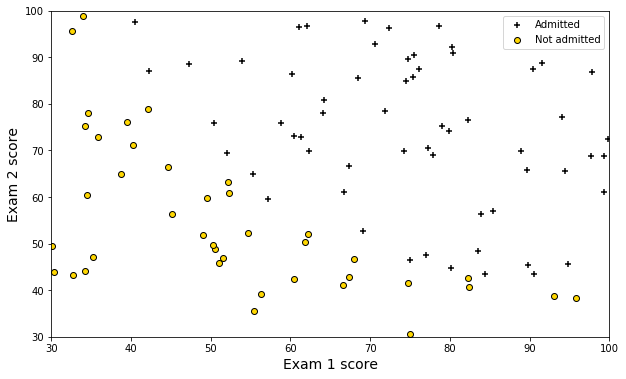

In [3]:
# Plot
plt.figure()
plt.scatter(design[:,1][admit_cut],design[:,2][admit_cut],c='k',marker='+',label='Admitted')
plt.scatter(design[:,1][reject_cut],design[:,2][reject_cut],marker='o',edgecolor='k',facecolor='gold',label='Not admitted')
plt.xlim(30,100)
plt.ylim(30,100)
plt.xlabel('Exam 1 score',fontsize=14)
plt.ylabel('Exam 2 score', fontsize=14)
plt.legend(loc='upper right',fontsize='medium')
plt.show()

## 1.2 Implementation

In [4]:
def sigmoid(z):
    '''
    Computes the sigmoid function - the hypothesis for Logistic Regression - given input z
    In the case of Logistic Regression z = X*Theta (which is an m by 1 vector)
    so that H = 1/(1+exp(-X*Theta))
    
    Parameters
    ----------
    z: array
    
    Returns
    -------
    value of sigmoid at the given vector z
    '''
    return 1/(1+np.exp(-z))

In [5]:
sigmoid(0) # != 1/2

0.5

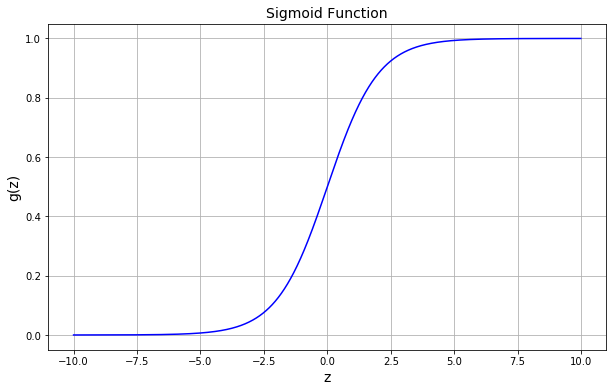

In [6]:
# Let's plot the sigmoid and confirm its shape
plt.figure()
plt.grid(True)
zz = np.arange(-10,10,0.01)
plt.plot(zz,sigmoid(zz),'-b')
plt.xlabel('z',fontsize=14)
plt.ylabel('g(z)',fontsize=14)
plt.title('Sigmoid Function',fontsize=14)
plt.show()

- Note that the `@` operator is used for matrix multiplication, a feature introduced in Python 3.5 and the `*` operator is used for element-wise multiplication; see https://stackoverflow.com/questions/27385633/what-is-the-symbol-for-in-python

In [7]:
# Let's define the cost function for Logistic Regression
# I will add the regularization bit now and make it an optional parameter of the function
def costFunction(theta,design,output,reg_param=0):
    '''
    Computes the cost function J = -1/m{Y^T*Log(g(X*Theta))+(1-Y)^T*Log(1-g(X*Theta))}+lambda/2m{Theta^T*Theta}
    which is a function of Theta for a given sample set; the regularization term is included only if a regularization parameter is passed in 
    X is the design matrix of shape m by (n+1), Theta is the fit (n+1) parameter vector, Y is the m output vector of class labels
    and lambda is the regulatization parameter
    Returns the scalar J
    
    Parameters
    ----------
    theta: (n+1) fit parameter vector
    design: m by (n+1) design matrix
    output: m-dimensional output vector
    reg_flag (optional): scalar, regularization parameter; default is 0
    
    Returns
    -------
    costJ: scalar, value of the cost function
    '''
    
    m = np.shape(design)[0] # sample size
    hypothesis = sigmoid(design @ theta)
#    costJ = -1/m*(output.T @ np.log(hypothesis)+((1-output).T @ np.log(1-hypothesis)))+reg_param/(2*m)*(theta.T @ theta) # including theta0 in regularization
    costJ = -1/m*(output.T @ np.log(hypothesis)+((1-output).T @ np.log(1-hypothesis)))+reg_param/(2*m)*(theta[1:].T @ theta[1:]) # don't regularize the theta0 parameter
                  
    return costJ

In [8]:
# Test with initial theta of zeros
costFunction(theta,design,class_label)

0.69314718055994518

In [9]:
# Let's define gradient descent for Logistic Regression
def gradientDescent(theta,design,output,history_j=None,alpha=0.1,iterations=0,reg_param=0):
    '''
    Performs update of (n+1) fit parameters with batch gradient descent method, i.e
        Theta_J := Theta_j - alpha*dJ/dTheta_j for j=0,2,..,n
                 = {1-alpha*lambda/m}Theta-alpha/m{X^T*{g(X*Theta)-Y}}
    The regularization factor will only be added if a regularization parameter is passed in
    
    Parameters
    ----------
    theta: (n+1) fit parameter vector
    design: m by (n+1) design matrix
    output: m-dimensional output vector
    history_j (optional): dictionary with key "theta_history" where we keep all values of theta vector as we iterate
    alpha: scalar learning rate
    iterations: number of iterations
    reg_param: scalar, regularization parameter; default is 0
    '''
    print('Initial values:')
    for idx_theta,ii_theta in enumerate(theta):
        print('\tTheta_{}: {}'.format(str(idx_theta),ii_theta))
    print('\tCost Function J: {}'.format(costFunction(theta,design,output)))
    m = np.shape(design)[0] # sample size
    hypothesis = sigmoid(design @ theta)

    if True:
        # Step through parameter space
        for ii_iter in range(iterations):
#            theta[:] = (1-alpha*reg_param/m)*theta - alpha/m*(design.T @ (hypothesis-output)) # including theta0 in regularization
                                                                                              # [:] will assign values to the elements of the theta array and thus will change the original array
                                                                                              # if we do theta = tem_theta instead, the value it pointed to before the assignment in this function will remain unchanged        
            theta[0] -= - alpha/m*(design[:,0].T @ (hypothesis-output)) # don't regularize theta0
            theta[1:] = (1-alpha*reg_param/m)*theta[1:] - alpha/m*(design[:,1:].T @ (hypothesis-output)) # regularized all other thetas
            if history_j is not None: # if we've provided a dictionary, save the respective value
                history_j["theta_history"][ii_iter] = theta
                history_j["J_history"][ii_iter] = costFunction(theta,design,output)

        print('\nAfter {} iterations, final values:'.format(iterations))
        for idx_theta,ii_theta in enumerate(theta):
            print('\tTheta_{}: {}'.format(str(idx_theta),ii_theta))

        print('\tCost Function J: {}'.format(costFunction(theta,design,output)))

In [10]:
# The assigment asks to use a minimization function but first let's try out doing GD with our function

# As we iterate through different values of theta we want to keep a record of J
history_j = dict.fromkeys(['theta_history','J_history'])

# How many iterations of GD? Learning rate?
iterations = 100
alpha = 0.01

# Allocate space
history_j['J_history'] = np.empty(iterations)
history_j['theta_history'] = np.empty((iterations,np.shape(theta)[0]))

In [11]:
# Apply our GD
gradientDescent(theta,design,class_label,history_j,alpha,iterations)

Initial values:
	Theta_0: 0.0
	Theta_1: 0.0
	Theta_2: 0.0
	Cost Function J: 0.6931471805599452

After 100 iterations, final values:
	Theta_0: -0.10000000000000007
	Theta_1: 12.009216589291151
	Theta_2: 11.262842205513605
	Cost Function J: nan


/home/les67/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: RuntimeWarning: divide by zero encountered in log


- The issue comes from the computing the cost function with the optimized parameters for theta
- This is because `z = X*`$\theta$ gives large numbers which when computing `np.exp(-X*`$\theta$) is subject to very large numbers and throws out the error:
    - `/home/les67/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':`
    - We are overriding the register
- There are a few workarounds for this. See discussions here: https://stackoverflow.com/questions/9559346/deal-with-overflow-in-exp-using-numpy, https://stackoverflow.com/questions/9478663/logit-and-inverse-logit-functions-for-extreme-values/9478781#9478781
- However since the homework asks us to use a minimizing function to find $\theta$ we will leave this alone in the interest of time

### - Notes on minimizing in Python:
- There are two minimization functions we can use from the scipy.optmize library:
    1. `minimize` (https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize): minimizes a scalar function of one or more variables. Can take derivative functions gradient and/or hessian, constraints, bounds, tolerance, choose from a number of solver algorithms like Newton-CG, BFGS, L-BFGS-B, Nelder-Mead, etc
    2. `fmin` (https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin.html): minimizes a function using a Nelder-Mead simplex downhill algorithm but only uses function values, not derivatives or second derivatives. From the notes in the man page we see that "it will usually be slower than an algorithm that uses first or second derivative information"

In [12]:
# Let's try minimize()
# The solver Nelder-Mead works and it's very fast

theta = np.zeros(np.shape(design)[1]) # re-initialize theta
optimized_theta = minimize(costFunction,theta,args=(design,class_label),method='Nelder-Mead',options={'disp':True,'maxiter': 400})
                            # args=() are the rest of the arguments that the function of interest takes
                            # returns an OptimizeResult object that includes the solution array among other information

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 157
         Function evaluations: 287


In [13]:
# Let's see with fmin()
# Should be very similar in performance since the same solver is being used

theta = np.zeros(np.shape(design)[1]) # re-initialize theta
optimized_theta = fmin(costFunction,theta,args=(design,class_label),maxiter=400,disp=True) # returns the solution array

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 157
         Function evaluations: 287


In [14]:
# Now let's confirm the value of the cost function at this optimized theta
costFunction(optimized_theta,design,class_label)

0.2034977015902151

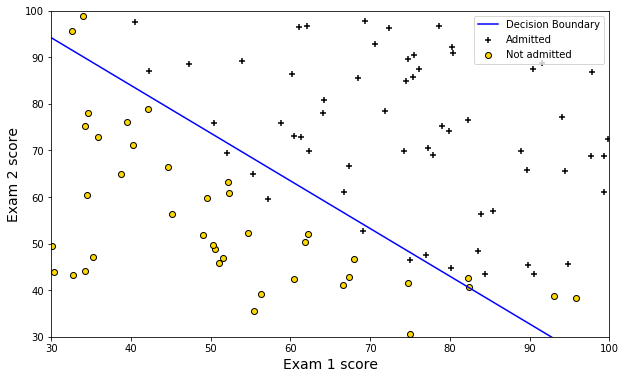

In [15]:
# Let's plot the decision boundary against the 2D feature space
# Recall that the decision boundary is defined by hypothesis(x|theta)==0 which is our 50% probability
# Since for this problem we have hypothesis(x|theta)=theta0+theta1*x1+theta2*x2=0
# we can solve for x2 as a function of x1 and the theta's: x2 = -(theta1/theta2)*x1-(theta0/theta2)

# Plot
plt.figure()
plt.scatter(design[:,1][admit_cut],design[:,2][admit_cut],c='k',marker='+',label='Admitted')
plt.scatter(design[:,1][reject_cut],design[:,2][reject_cut],marker='o',edgecolor='k',facecolor='gold',label='Not admitted')
x1 = np.arange(30,100,1)
plt.plot(x1,-(optimized_theta[1]/optimized_theta[2])*x1-(optimized_theta[0]/optimized_theta[2]),c='b',label='Decision Boundary')
plt.xlim(30,100)
plt.ylim(30,100)
plt.xlabel('Exam 1 score',fontsize=14)
plt.ylabel('Exam 2 score', fontsize=14)
plt.legend(loc='upper right',fontsize='medium')
plt.show()

In [16]:
# Predictions for a student with exam 1 score 45 and exam 2 score 85
sigmoid(np.array([1,45,85]) @ optimized_theta)

0.77629159041124107

In [17]:
def prediction(theta,design):
    '''
    Makes prediction of class label in a binary problem given an optimized parameter vector theta
    and a dataset (in the format of the design matrix). The prediction is: If hypothesis(x|theta)>=0.5 label 1
    else label 0
    
    Parameters
    ----------
    theta: (n+1) fit parameter vector
    design: m by (n+1) design matrix
    
    Returns
    -------
    label: m-dimensional vector, either 0 or 1 for class label prediction
    '''    
    probability = sigmoid(design @ theta)
    label = (probability>=0.5).astype(int) # converts boolean true to 1 and false to 0
    
    return label

In [18]:
# Prediction of our hypothesis (w/ optimized theta of course) on our training set
prediction_label = prediction(optimized_theta,design)

In [19]:
def accuracy(prediction,og_label):
    '''
    Computes percentage accuracy of prediction of class labels by direct comparison to given (original) labels
    in training data set
    
    Parameters
    ----------
    predictions: m-dimensional vector of prediction labels
    og_label: m-dimensional vector of original training labels
    
    Returns
    -------
    acc: scalar, percentage accuracy 
    '''
    m = np.size(og_label)
    acc = sum(prediction==og_label)/m # summing True booleans
    return acc 

In [20]:
print('Training accuracy: {:0.1f} %'.format(accuracy(prediction_label,class_label)*100))

Training accuracy: 89.0 %


# 2. Regularized Logistic Regression
- Assignment: Implement Regularized Logistic Regression to predict whether microchips from a fabrication plant passes quality assurance (QA) 

## 2.1 Visualizing the Data

In [21]:
test1,test2,class_label=np.loadtxt('ex2data2.txt',delimiter=',',unpack=True)

# design matrix
design = np.c_[np.ones_like(test1),test1,test2]

# initial theta
theta = np.zeros(np.shape(design)[1])

# label cuts
positive_cut = (class_label==1)
negative_cut = (class_label==0)

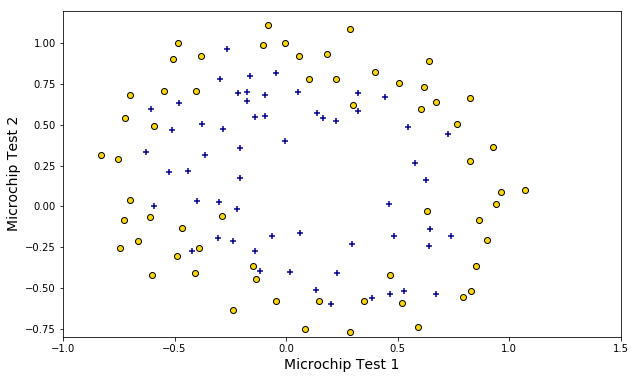

In [22]:
# Plot
plt.figure()
plt.scatter(test1[positive_cut],test2[positive_cut],marker='+',c='darkblue',edgecolors='k')
plt.scatter(test1[negative_cut],test2[negative_cut],marker='o',c='gold',edgecolors='k')
plt.xlim(-1,1.5)
plt.ylim(-0.8,1.2)
plt.xlabel('Microchip Test 1',fontsize=14)
plt.ylabel('Microchip Test 2',fontsize=14)
plt.show()

## 2.2 Feature Mapping

- The following function will generate all polynomial terms of $x_1$ and $x_2$ (our two features) up to some degree $n$. For example, for degree $n=2$ we want:
$$ x_1,\,x_2,\,x_1^2,\,x_1x_2,\,x_2^2 $$
each of which can be expressed as a product $x_1^ax_2 ^b$ for suitable powers $a$ and $b$
- These product terms can be found from the binomial theorem: 
$$ (x_1+x_2)^n = \sum_{k=0}^n {n \choose k} x_1^{n - k} x_2^k $$
where
$$ {n \choose k} = \frac{n!}{k!(n-k)!} $$
- The binomial theorem then tells us that for some fixed degree $n$ we will have $n+1$ terms of the form $x_1^{n - k} x_2^k$ with $k$ ranging from 0 to $n$
- Furthermore, since we want all mixed polynomial terms from degrees 1 to $n$ we'll have:
$$ \sum_{j=1}^n (j+1) = \frac{1}{2}n(n+3)$$
total product terms 

In [23]:
def mapFeature(x1,x2,degree=1):
    '''
    For two input features x1 and x2 (of the same size!), it produces feature mapping to polynomial terms x1^a*x2^b up to degree n
    and returns a design matrix populated with these. Returning the design matrix means that it also includes the
    x0 column which is all 1's
    
    Parameters
    ----------
    x1 : m-dimensional feature vector
    x2: m-dimensional feature vector
    degree: degree of highest polynomial to generate from x1 and x2, integer >= 1
    
    Returns
    -------
    design: design matrix of shape m by 0.5*degree(degree+1)+1, each column is a  product term x1^a*x2^b
    feature_labels: list of labels for each column in design matrix
    '''
    n_terms = int(1/2*degree*(degree+3)) # total number of terms 
    design = np.empty((np.size(x1),n_terms)) # allocate space for n_terms product-terms x^a*x^b;
                                             # each column is one such terms and it goes in 
    feature_labels = ['$x_0$'] # initializing with x0 column label
    
    ii_col = 0
    for ii_deg in range(1,degree+1): # for degree 1 to n, excluding n=0 case; +1 bc range(z) goes from 0 to z-1
        for k in range(ii_deg+1): # for fixed degree n, from k=0 to n; +1 bc range(z) goes from 0 to z-1
            x1_power = (ii_deg-k)
            x2_power = k
            design[:,ii_col] = (x1**(x1_power))*(x2**(x2_power)) # * is element-wise multiplication, ** raises a matrix to a power  
            # Create feature column labels
            if x1_power==0:
                feature_labels.append('$x_2^{{{}}}$'.format(x2_power)) # double { are needed in order to display { in string
                                                                       # since we have format we need a third set of {
            elif x2_power==0:
                feature_labels.append('$x_1^{{{}}}$'.format(x1_power))                
            else:
                feature_labels.append('$x_1^{{{}}}x_2^{{{}}}$'.format(x1_power,x2_power))
            ii_col += 1
            
    design = np.c_[np.ones_like(x1),design] # adding x0 column
    
    return design,feature_labels

In [24]:
# Design matrix w/ feature mapping
design,column_labels = mapFeature(test1,test2,degree=6)

In [25]:
# Turn into a pandas dataframe and display to see design matrix structure
df = pd.DataFrame(design,columns=column_labels)
df

,$x_0$,$x_1^{1}$,$x_2^{1}$,$x_1^{2}$,$x_1^{1}x_2^{1}$,$x_2^{2}$,$x_1^{3}$,$x_1^{2}x_2^{1}$,$x_1^{1}x_2^{2}$,$x_2^{3}$,...,$x_1^{2}x_2^{3}$,$x_1^{1}x_2^{4}$,$x_2^{5}$,$x_1^{6}$,$x_1^{5}x_2^{1}$,$x_1^{4}x_2^{2}$,$x_1^{3}x_2^{3}$,$x_1^{2}x_2^{4}$,$x_1^{1}x_2^{5}$,$x_2^{6}$
0,1.0,0.051267,0.699560,0.002628,0.035864,0.489384,1.347453e-04,0.001839,0.025089,3.423536e-01,...,8.998098e-04,1.227829e-02,1.675424e-01,1.815630e-08,2.477505e-07,3.380660e-06,4.613055e-05,6.294709e-04,8.589398e-03,1.172060e-01
1,1.0,-0.092742,0.684940,0.008601,-0.063523,0.469143,-7.976812e-04,0.005891,-0.043509,3.213347e-01,...,2.763825e-03,-2.041205e-02,1.507518e-01,6.362953e-07,-4.699318e-06,3.470651e-05,-2.563226e-04,1.893054e-03,-1.398103e-02,1.032560e-01
2,1.0,-0.213710,0.692250,0.045672,-0.147941,0.479210,-9.760555e-03,0.031616,-0.102412,3.317332e-01,...,1.515091e-02,-4.907685e-02,1.589699e-01,9.526844e-05,-3.085938e-04,9.995978e-04,-3.237900e-03,1.048821e-02,-3.397345e-02,1.100469e-01
3,1.0,-0.375000,0.502190,0.140625,-0.188321,0.252195,-5.273438e-02,0.070620,-0.094573,1.266497e-01,...,1.781011e-02,-2.385083e-02,3.194040e-02,2.780914e-03,-3.724126e-03,4.987251e-03,-6.678793e-03,8.944062e-03,-1.197765e-02,1.604015e-02
4,1.0,-0.513250,0.465640,0.263426,-0.238990,0.216821,-1.352032e-01,0.122661,-0.111283,1.009603e-01,...,2.659554e-02,-2.412849e-02,2.189028e-02,1.827990e-02,-1.658422e-02,1.504584e-02,-1.365016e-02,1.238395e-02,-1.123519e-02,1.019299e-02
5,1.0,-0.524770,0.209800,0.275384,-0.110097,0.044016,-1.445130e-01,0.057775,-0.023098,9.234565e-03,...,2.543047e-03,-1.016696e-03,4.064690e-04,2.088401e-02,-8.349308e-03,3.338005e-03,-1.334515e-03,5.335313e-04,-2.133027e-04,8.527719e-05
6,1.0,-0.398040,0.034357,0.158436,-0.013675,0.001180,-6.306380e-02,0.005443,-0.000470,4.055512e-05,...,6.425385e-06,-5.546100e-07,4.787141e-08,3.977043e-03,-3.432803e-04,2.963039e-05,-2.557560e-06,2.207569e-07,-1.905473e-08,1.644718e-09
7,1.0,-0.305880,-0.192250,0.093563,0.058805,0.036960,-2.861892e-02,-0.017987,-0.011305,-7.105572e-03,...,-6.648156e-04,-4.178462e-04,-2.626224e-04,8.190426e-04,5.147801e-04,3.235467e-04,2.033538e-04,1.278108e-04,8.033094e-05,5.048915e-05
8,1.0,0.016705,-0.404240,0.000279,-0.006753,0.163410,4.661648e-06,-0.000113,0.002730,-6.605685e-02,...,-1.843363e-05,4.460706e-04,-1.079435e-02,2.173096e-11,-5.258619e-10,1.272520e-08,-3.079338e-07,7.451610e-06,-1.803196e-04,4.363507e-03
9,1.0,0.131910,-0.513890,0.017400,-0.067787,0.264083,2.295267e-03,-0.008942,0.034835,-1.357096e-01,...,-2.361380e-03,9.199376e-03,-3.583858e-02,5.268249e-06,-2.052385e-05,7.995603e-05,-3.114897e-04,1.213490e-03,-4.727468e-03,1.841709e-02


## 2.3 Cost Function and Gradient
- I already implemented the full version above so we just go ahead and test it

In [26]:
# initialize new theta
theta = np.zeros(np.shape(design)[1])

# Test with initial theta of zeros and no regularization
costFunction(theta,design,class_label)

0.69314718055994529

Initial values:
	Theta_0: 0.0
	Theta_1: 0.0
	Theta_2: 0.0
	Theta_3: 0.0
	Theta_4: 0.0
	Theta_5: 0.0
	Theta_6: 0.0
	Theta_7: 0.0
	Theta_8: 0.0
	Theta_9: 0.0
	Theta_10: 0.0
	Theta_11: 0.0
	Theta_12: 0.0
	Theta_13: 0.0
	Theta_14: 0.0
	Theta_15: 0.0
	Theta_16: 0.0
	Theta_17: 0.0
	Theta_18: 0.0
	Theta_19: 0.0
	Theta_20: 0.0
	Theta_21: 0.0
	Theta_22: 0.0
	Theta_23: 0.0
	Theta_24: 0.0
	Theta_25: 0.0
	Theta_26: 0.0
	Theta_27: 0.0
	Cost Function J: 0.6931471805599453

After 13000 iterations, final values:
	Theta_0: 0.11016949152544613
	Theta_1: -0.23127271997773055
	Theta_2: -0.0009573272611059675
	Theta_3: -0.61971917987213
	Theta_4: -0.1415760515639707
	Theta_5: -0.4636368147759317
	Theta_6: -0.22595369539244783
	Theta_7: -0.0901542320830811
	Theta_8: -0.10084519717303625
	Theta_9: -0.28898469747283995
	Theta_10: -0.48436331794993714
	Theta_11: -0.027563995105435012
	Theta_12: -0.15830125950719717
	Theta_13: -0.03810955211279184
	Theta_14: -0.4837994632722236
	Theta_15: -0.24583063652890005
	

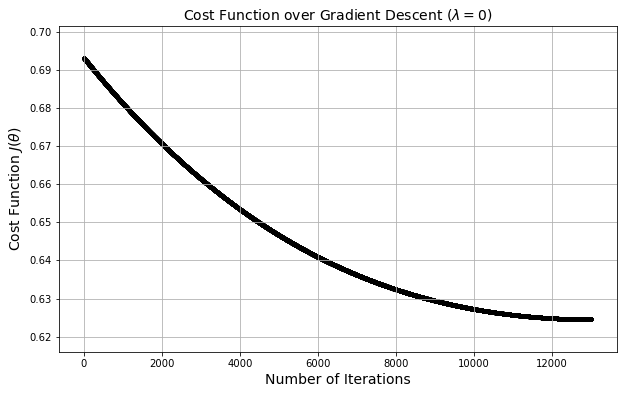

In [27]:
# As we iterate through different values of theta we want to keep a record of J
history_j = dict.fromkeys(['theta_history','J_history'])

# How many iterations of GD? Learning rate?
iterations = 13000
alpha = 0.001

# Allocate space
history_j['J_history'] = np.empty(iterations)
history_j['theta_history'] = np.empty((iterations,np.shape(theta)[0]))

# initialize new theta of zeros
theta = np.zeros(np.shape(design)[1])
# initial regularization parameter, lambda = 1
reg_param = 1
# Apply our GD
gradientDescent(theta,design,class_label,history_j,alpha,iterations,reg_param)

# Plot the values of the cost function over iterations of GD
plt.figure()
plt.clf()
plt.grid(True)
plt.scatter(np.arange(iterations),history_j['J_history'],marker='.',c='k')
plt.xlabel("Number of Iterations",fontsize=14)
plt.ylabel("Cost Function $J(\\theta)$",fontsize=14)
plt.title("Cost Function over Gradient Descent ($\lambda=0$)",fontsize=14)
plt.show()

Initial values:
	Theta_0: 1.0
	Theta_1: 1.0
	Theta_2: 1.0
	Theta_3: 1.0
	Theta_4: 1.0
	Theta_5: 1.0
	Theta_6: 1.0
	Theta_7: 1.0
	Theta_8: 1.0
	Theta_9: 1.0
	Theta_10: 1.0
	Theta_11: 1.0
	Theta_12: 1.0
	Theta_13: 1.0
	Theta_14: 1.0
	Theta_15: 1.0
	Theta_16: 1.0
	Theta_17: 1.0
	Theta_18: 1.0
	Theta_19: 1.0
	Theta_20: 1.0
	Theta_21: 1.0
	Theta_22: 1.0
	Theta_23: 1.0
	Theta_24: 1.0
	Theta_25: 1.0
	Theta_26: 1.0
	Theta_27: 1.0
	Cost Function J: 2.0204415350048404

After 45000 iterations, final values:
	Theta_0: 2.557202831561355
	Theta_1: 0.3963207107218973
	Theta_2: 0.271194518007294
	Theta_3: 0.15121949743362548
	Theta_4: 0.6550981043418299
	Theta_5: 0.08566001620594814
	Theta_6: 0.46351518300955863
	Theta_7: 0.5942780369377316
	Theta_8: 0.6172026885728269
	Theta_9: 0.3135742760052174
	Theta_10: 0.3507577236907685
	Theta_11: 0.6735437074944547
	Theta_12: 0.5576647101298277
	Theta_13: 0.6788273397458272
	Theta_14: 0.25191446340353163
	Theta_15: 0.4940658023766215
	Theta_16: 0.6446611469544

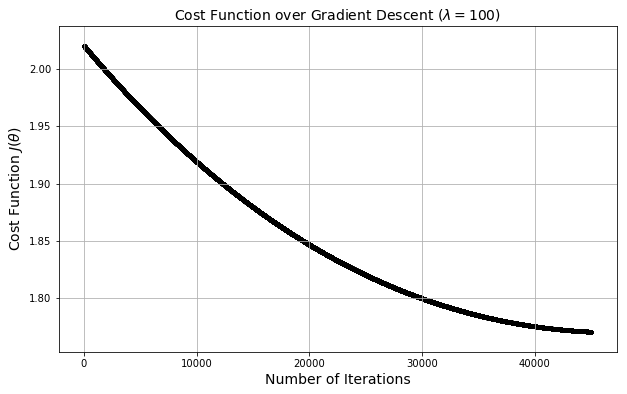

In [28]:
# As we iterate through different values of theta we want to keep a record of J
history_j = dict.fromkeys(['theta_history','J_history'])

# How many iterations of GD? Learning rate?
iterations = 45000
alpha = 0.0001

# new theta of all 1's
theta = np.ones(np.shape(design)[1])

history_j['J_history'] = np.empty(iterations)
history_j['theta_history'] = np.empty((iterations,np.shape(theta)[0]))

# now try with lambda = 10
reg_param = 10
# Apply our GD
gradientDescent(theta,design,class_label,history_j,alpha,iterations,reg_param)

# Plot the values of the cost function over iterations of GD
plt.figure()
plt.clf()
plt.grid(True)
plt.scatter(np.arange(iterations),history_j['J_history'],marker='.',c='k')
plt.xlabel("Number of Iterations",fontsize=14)
plt.ylabel("Cost Function $J(\\theta)$",fontsize=14)
plt.title("Cost Function over Gradient Descent ($\lambda=100$)",fontsize=14)
plt.show()

- Now let's try optimizing using scipy methods in the latter scenario (i.e $\lambda = 10$):

In [29]:
# initialize new theta
theta = np.ones(np.shape(design)[1])

# Test with initial theta of zeros and no regularization
costFunction(theta,design,class_label)

2.0204415350048404

In [31]:
# Using fmin() with lambda = 10
reg_param = 10
optimized_theta = fmin(costFunction,theta,args=(design,class_label,reg_param),xtol=0.1,disp=True) # returns the solution array

In [32]:
# Using minimize() with the 'BFGS' algorithm with lambda = 10
reg_param = 10
optimized_theta = minimize(costFunction,theta,args=(design,class_label,reg_param),tol=0.03725,method='BFGS',options={'disp':True})

Optimization terminated successfully.
         Current function value: 0.714261
         Iterations: 6
         Function evaluations: 210
         Gradient evaluations: 7


- If the tolerance is any smaller (I played with several), we run into warnings `Warning: Maximum number of function evaluations has been exceeded`
- In minimize(), the `BFGS` solver finds a lower minimum than the `Nelder-Mead` which fmin uses by construction

## 2.4 Plotting the Decision Boundary
- Based on the above results we'll use minimize() with `BFGS`, `tol = 0.03725`, and $\theta_{initial}=0$ initial to plot the decision boundary for $\lambda=1$

In [33]:
# Get optimal theta
#theta = np.ones(np.shape(design)[1])
theta = np.zeros(np.shape(design)[1])
reg_param = 1
#optimized_theta = minimize(costFunction,theta,args=(design,class_label,reg_param),tol=0.03725,method='BFGS',options={'disp':True})
optimized_theta = minimize(costFunction,theta,args=(design,class_label,reg_param),tol=0.02,method='BFGS',options={'disp':True})
optimized_theta = optimized_theta.x # x is the solution array

Optimization terminated successfully.
         Current function value: 0.533596
         Iterations: 12
         Function evaluations: 390
         Gradient evaluations: 13


In [34]:
test1_min, test1_max = -1, 1.5
test2_min, test2_max = -1, 1.5
h = (test1_max-test1_min)/50 # step size in grid
test1_range, test2_range = np.meshgrid(np.arange(test1_min, test1_max, h),np.arange(test2_min, test2_max, h))
grid_predict = np.empty((np.shape(test1_range)[0],np.shape(test1_range)[1])) # allocate space for cost function over grid

# Since the function costFunction() was not written to expect and "x" and a "y" but rather a theta_i = [x_i,y_i]
# I can't call it directly with the mesh grid values. Rather I will loop through the values and evaluate it at each point
for idx_test1,ii_test1 in enumerate(test1_range[0,:]):
    for idx_test2,ii_test2 in enumerate(test2_range[:,0]):
        temp_design, _ = mapFeature(ii_test1,ii_test2,degree=6) # get the expanded design matrix; ignore feature label return
        grid_predict[idx_test2][idx_test1] = sigmoid(temp_design @ optimized_theta) # hypothesis function value at grid point

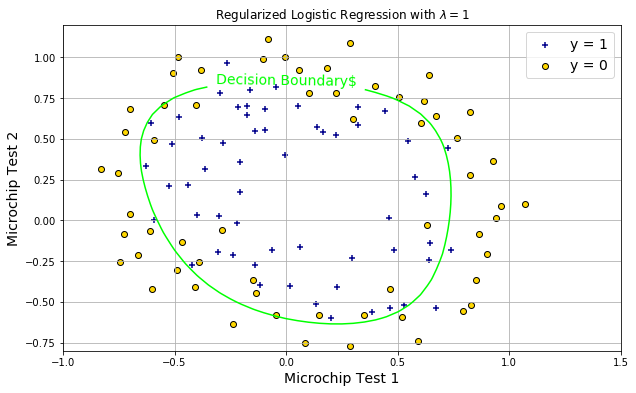

In [35]:
# Plot
plt.figure()
plt.grid(True)
CS = plt.contour(test1_range,test2_range,grid_predict,levels=[0.5],colors='lime') # only plot where prediction = 0.5
myfmt = { 0.5:'Decision Boundary$'} # key must match level plotted
plt.clabel(CS, inline=True, fontsize=14, fmt=myfmt) # custom label with fmt; inline controls wether contour below label gets removed
plt.scatter(test1[positive_cut],test2[positive_cut],marker='+',c='darkblue',edgecolors='k',label='y = 1')
plt.scatter(test1[negative_cut],test2[negative_cut],marker='o',c='gold',edgecolors='k',label='y = 0')
plt.xlim(-1,1.5)
plt.ylim(-0.8,1.2)
plt.legend(loc='upper right',fontsize=14)
plt.xlabel('Microchip Test 1',fontsize=14)
plt.ylabel('Microchip Test 2',fontsize=14)
plt.title('Regularized Logistic Regression with $\lambda = 1$')
plt.show()

In [36]:
# Prediction of our hypothesis (w/ optimized theta of course) on our training set
prediction_label = prediction(optimized_theta,design)
print('Training accuracy: {:0.1f} %'.format(accuracy(prediction_label,class_label)*100))

Training accuracy: 81.4 %


## 2.5 Optional
- Again plot decision boundaries for different values of regularization parameter $\lambda\in\{0,10,100\}$ with $\theta_{initial}\in\{0,1\}$ wherever suitable for convergence of minimization
 - Note that tolerances also change to handle convergence

Optimization terminated successfully.
         Current function value: 0.295260
         Iterations: 131
         Function evaluations: 3960
         Gradient evaluations: 132


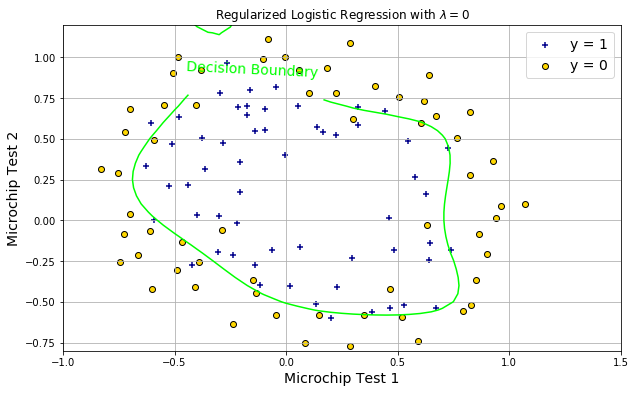

Training accuracy: 86.4 %


In [37]:
# Lambda = 0

# Get optimal theta
theta = np.zeros(np.shape(design)[1])
reg_param = 0
optimized_theta = minimize(costFunction,theta,args=(design,class_label,reg_param),tol=0.0003,method='BFGS',options={'disp':True})
optimized_theta = optimized_theta.x 

# Prediction over grid for this theta
grid_predict = np.empty((np.shape(test1_range)[0],np.shape(test1_range)[1]))
for idx_test1,ii_test1 in enumerate(test1_range[0,:]):
    for idx_test2,ii_test2 in enumerate(test2_range[:,0]):
        temp_design, _ = mapFeature(ii_test1,ii_test2,degree=6)
        grid_predict[idx_test2][idx_test1] = sigmoid(temp_design @ optimized_theta)
    
# Plot
plt.figure()
plt.grid(True)
CS = plt.contour(test1_range,test2_range,grid_predict,levels=[0.5],colors='lime') # only plot where prediction = 0.5
myfmt = { 0.5:'Decision Boundary'} # key must match level plotted
plt.clabel(CS, inline=True, fontsize=14, fmt=myfmt) # custom label with fmt; inline controls wether contour below label gets removed
plt.scatter(test1[positive_cut],test2[positive_cut],marker='+',c='darkblue',edgecolors='k',label='y = 1')
plt.scatter(test1[negative_cut],test2[negative_cut],marker='o',c='gold',edgecolors='k',label='y = 0')
plt.xlim(-1,1.5)
plt.ylim(-0.8,1.2)
plt.legend(loc='upper right',fontsize=14)
plt.xlabel('Microchip Test 1',fontsize=14)
plt.ylabel('Microchip Test 2',fontsize=14)
plt.title('Regularized Logistic Regression with $\lambda = 0$')
plt.show()

# Accuracy
prediction_label = prediction(optimized_theta,design)
print('Training accuracy: {:0.1f} %'.format(accuracy(prediction_label,class_label)*100))

Optimization terminated successfully.
         Current function value: 0.714261
         Iterations: 6
         Function evaluations: 210
         Gradient evaluations: 7


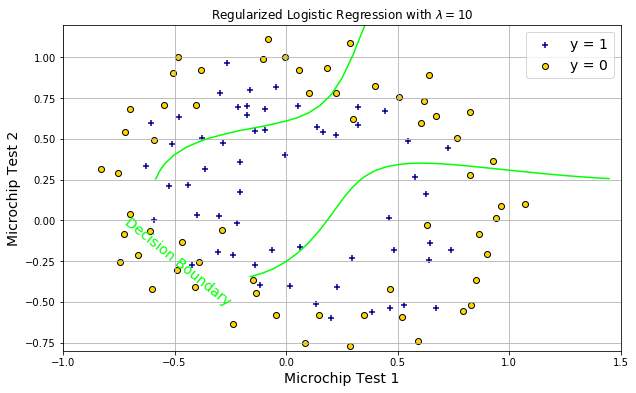

Training accuracy: 61.9 %


In [38]:
# Lambda = 10

# Get optimal theta
theta = np.ones(np.shape(design)[1])
reg_param = 10
optimized_theta = minimize(costFunction,theta,args=(design,class_label,reg_param),tol=0.03725,method='BFGS',options={'disp':True})
optimized_theta = optimized_theta.x

# Prediction over grid for this theta
grid_predict = np.empty((np.shape(test1_range)[0],np.shape(test1_range)[1]))
for idx_test1,ii_test1 in enumerate(test1_range[0,:]):
    for idx_test2,ii_test2 in enumerate(test2_range[:,0]):
        temp_design, _ = mapFeature(ii_test1,ii_test2,degree=6)
        grid_predict[idx_test2][idx_test1] = sigmoid(temp_design @ optimized_theta) 
    
# Plot
plt.figure()
plt.grid(True)
CS = plt.contour(test1_range,test2_range,grid_predict,levels=[0.5],colors='lime') # only plot where prediction = 0.5
myfmt = { 0.5:'Decision Boundary'} # key must match level plotted
plt.clabel(CS, inline=True, fontsize=14, fmt=myfmt) # custom label with fmt; inline controls wether contour below label gets removed
plt.scatter(test1[positive_cut],test2[positive_cut],marker='+',c='darkblue',edgecolors='k',label='y = 1')
plt.scatter(test1[negative_cut],test2[negative_cut],marker='o',c='gold',edgecolors='k',label='y = 0')
plt.xlim(-1,1.5)
plt.ylim(-0.8,1.2)
plt.legend(loc='upper right',fontsize=14)
plt.xlabel('Microchip Test 1',fontsize=14)
plt.ylabel('Microchip Test 2',fontsize=14)
plt.title('Regularized Logistic Regression with $\lambda = 10$')
plt.show()

# Accuracy
prediction_label = prediction(optimized_theta,design)
print('Training accuracy: {:0.1f} %'.format(accuracy(prediction_label,class_label)*100))

Optimization terminated successfully.
         Current function value: 0.689017
         Iterations: 4
         Function evaluations: 150
         Gradient evaluations: 5


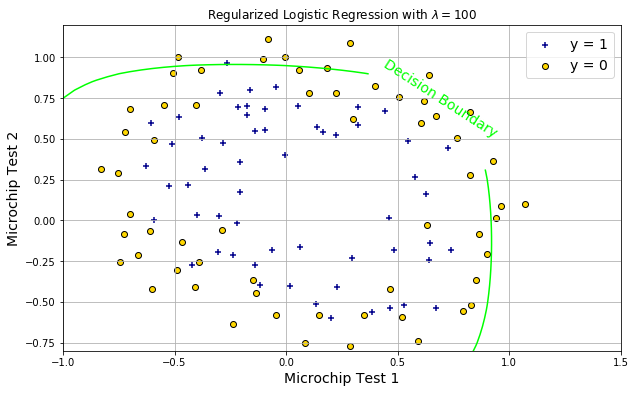

Training accuracy: 58.5 %


In [39]:
# Lambda = 100

# Get optimal theta
theta = np.ones(np.shape(design)[1])
reg_param = 100
optimized_theta = minimize(costFunction,theta,args=(design,class_label,reg_param),tol=0.04,method='BFGS',options={'disp':True})
optimized_theta = optimized_theta.x 

# Prediction over grid for this theta
grid_predict = np.empty((np.shape(test1_range)[0],np.shape(test1_range)[1]))
for idx_test1,ii_test1 in enumerate(test1_range[0,:]):
    for idx_test2,ii_test2 in enumerate(test2_range[:,0]):
        temp_design, _ = mapFeature(ii_test1,ii_test2,degree=6)
        grid_predict[idx_test2][idx_test1] = sigmoid(temp_design @ optimized_theta) 
    
# Plot
plt.figure()
plt.grid(True)
CS = plt.contour(test1_range,test2_range,grid_predict,levels=[0.5],colors='lime') # only plot where prediction = 0.5
myfmt = { 0.5:'Decision Boundary'} # key must match level plotted
plt.clabel(CS, inline=True, fontsize=14, fmt=myfmt) # custom label with fmt; inline controls wether contour below label gets removed
plt.scatter(test1[positive_cut],test2[positive_cut],marker='+',c='darkblue',edgecolors='k',label='y = 1')
plt.scatter(test1[negative_cut],test2[negative_cut],marker='o',c='gold',edgecolors='k',label='y = 0')
plt.xlim(-1,1.5)
plt.ylim(-0.8,1.2)
plt.legend(loc='upper right',fontsize=14)
plt.xlabel('Microchip Test 1',fontsize=14)
plt.ylabel('Microchip Test 2',fontsize=14)
plt.title('Regularized Logistic Regression with $\lambda = 100$')
plt.show()

# Accuracy
prediction_label = prediction(optimized_theta,design)
print('Training accuracy: {:0.1f} %'.format(accuracy(prediction_label,class_label)*100))

- From these results it seems that the best value for $\lambda$ is 1